In [4]:
import torch
import matplotlib.pyplot as plt
from Gibbs import generate_sw_tuples_batch
from MINE import MINE
from tqdm import tqdm
from torch.autograd import Variable
import numpy as np

import random
import os
def seed_torch(seed=1029):
	random.seed(seed)
	os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现
	np.random.seed(seed)
	torch.manual_seed(seed)
	torch.cuda.manual_seed(seed)
	torch.cuda.manual_seed_all(seed) # if you are using multi-GPU.
	torch.backends.cudnn.benchmark = False
	torch.backends.cudnn.deterministic = True
seed_torch()

p_current = 4 #p值
sample_size = 50000 #用来估计的样本数
iter_size = 10000
model = MINE(6, p_current)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
plot_loss = []

import json
with open('data/gibbs_data_p_is_{0}.json'.format(p_current), 'r') as datafile:
    data = json.load(datafile)

100%|██████████| 5000/5000 [11:45<00:00,  7.09it/s]


array(0.04747391, dtype=float32)

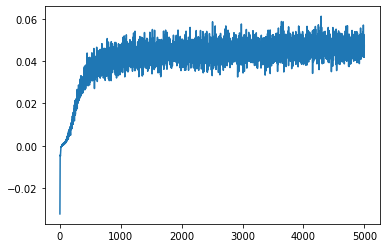

In [5]:

S = np.array([data[i]['S'][0] for i in range(len(data))][0:sample_size])
w = np.array([data[i]['w'] for i in range(len(data))][0:sample_size])
w_shuffle = np.random.permutation(w)
S_sample = Variable(torch.from_numpy(S).type(torch.FloatTensor), requires_grad=False)
w_sample = Variable(torch.from_numpy(w).type(torch.FloatTensor), requires_grad=False)
w_shuffle_sample = Variable(torch.from_numpy(w_shuffle).type(torch.FloatTensor), requires_grad=False)

kl = []
num_epoch = 5000
for epoch in tqdm(range(num_epoch)):
    '''
    S = np.array([data[i]['S'][0] for i in range(len(data))][(epoch*iter_size)%sample_size:((epoch+1)*iter_size-1)%sample_size+1])
    w = np.array([data[i]['w'] for i in range(len(data))][(epoch*iter_size)%sample_size:((epoch+1)*iter_size-1)%sample_size+1])
    w_shuffle = np.random.permutation(w)
    S_sample = Variable(torch.from_numpy(S).type(torch.FloatTensor), requires_grad=True)
    w_sample = Variable(torch.from_numpy(w).type(torch.FloatTensor), requires_grad=True)
    w_shuffle_sample = Variable(torch.from_numpy(w_shuffle).type(torch.FloatTensor), requires_grad=True)
    '''
    index = np.random.choice(np.arange(S.shape[0]),size=iter_size,replace=False)
    S_e = np.array([data[i]['S'][0] for i in range(len(data))][0:sample_size])[index]
    w_e = np.array([data[i]['w'] for i in range(len(data))][0:sample_size])[index]
    w_shuffle = np.random.permutation(w_e)
    S_sample = Variable(torch.from_numpy(S_e).type(torch.FloatTensor), requires_grad=False)
    w_sample = Variable(torch.from_numpy(w_e).type(torch.FloatTensor), requires_grad=False)
    w_shuffle_sample = Variable(torch.from_numpy(w_shuffle).type(torch.FloatTensor), requires_grad=False)
    
    
    pred_xy = model(S_sample, w_sample)
    pred_x_y = model(S_sample, w_shuffle_sample)
    
    loss1 = - torch.mean(pred_xy)
    loss2 = torch.log(torch.mean(torch.exp(pred_x_y)))
    loss = loss1 + loss2
    kl.append((-loss).data.numpy())
    model.zero_grad()
    loss.backward()
    optimizer.step()

x_plot = [x for x in range(num_epoch)]
plt.plot(x_plot, kl)
kl[len(kl)-1]

In [6]:
np.mean(kl[900:])

0.04502236